First improvement from preliminary: Having an overall setting script, containing the various imports to run the scikit-allel analysis.

In [1]:
%run ../scripts/notebook_settings.py

Using my newly created metadata

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

Picking the IDs to run the X PCA on

In [3]:
IDs = meta_data_samples.loc[(meta_data_samples.x_missing <= 0.01)
                             & (meta_data_samples.Sex == "F")].callset_index.values
meta_data_samples.loc[meta_data_samples.callset_index.isin(IDs)]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,callset_index,C_origin,x_missing
0,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,0,"Anubis, Tanzania",0.003591
1,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,1,"Anubis, Tanzania",0.004100
4,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,4,"Anubis, Tanzania",0.003674
6,PD_0205,05ANF1030116,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",F,6,"Anubis, Tanzania",0.004107
7,PD_0206,09ANF1040116,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",F,7,"Anubis, Tanzania",0.004304
...,...,...,...,...,...,...,...,...,...,...
194,PD_0772,16006_2008,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,194,"Cynocephalus, Central Tanzania",0.008772
195,PD_0773,16008_2010,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,195,"Cynocephalus, Central Tanzania",0.008856
196,PD_0774,16035_3003,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,196,"Cynocephalus, Central Tanzania",0.009476
212,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,212,"Kindae, Zambia",0.009835


Reading from the x_chr vcf

In [4]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_01_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

Functions to run the PCA, first two from http://alimanfoo.github.io/2015/09/28/fast-pca.html 

In [7]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

def offset_legend(fig):
    ax = fig.add_subplot(111)
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='best', bbox_to_anchor=(1,1))
    return lgd

def pruning_and_pca(gt, IDs, subsampling_n, size, n_iter):
    print("Investigating {} individuals".format(len(IDs)))
    gt = gt.take(IDs, axis=1)
    ac = gt.count_alleles()[:] #Allele counts for each pos
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filtering for biallelic 
    #and at least two individuals in the alt state
    gf = gt.compress(flt, axis=0) #Applying filter
    gn = gf.to_n_alt() #Transform genotype to number of non-ref alleles
    if subsampling_n > len(gn):
        subsampling_n = len(gn)-1
    vidx = np.random.choice(gn.shape[0], subsampling_n, replace=False) #Random subsampling
    vidx.sort()
    gnr = gn.take(vidx, axis=0) #Applying the random subsample
    gnu = ld_prune(gnr, size=size, step=200, threshold=.1, n_iter=n_iter) #Pruning based on LD
    if len(gnu) > 150000:
        print("Too large dataset for pca")
        return "Too large dataset for pca"
    gnu = gnu[:] #Taking it out of chunked storage
    coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson') #Running the pca
    #The plotting solution in the example is inflexible, so I will try to make it through seaborn.
    pca_df = pd.DataFrame()
    c_transposed = coords1.transpose()
    for i in range(len(c_transposed)):
        pc = "pc{}".format(i+1)
        pca_df[pc] = c_transposed[i]
    pca_df["callset_index"] = IDs
    pca_df_meta = pd.merge(pca_df, meta_data_samples)
    fig, ax = plt.subplots()
    sns.despine(ax=ax)
    x = np.arange(10)
    y = model1.explained_variance_ratio_ * 100
    ax.bar(x+.6, y, width=.8)
    ax.set_xticks(x+1)
    ax.set_xlim(0, 11)
    ax.set_xlabel('component')
    ax.set_ylabel('% variance explained')
    return pca_df_meta

Running the PCA. Inputs: The zarr, the IDs to collect. 
The first int depicts number of sites to randomly sample.
The second depicts the window to calculate LD for.
The third depicts the number of times to LD_prune.

Investigating 217 individuals
iteration 1 retaining 221834 removing 1873722 variants
iteration 2 retaining 47941 removing 173893 variants


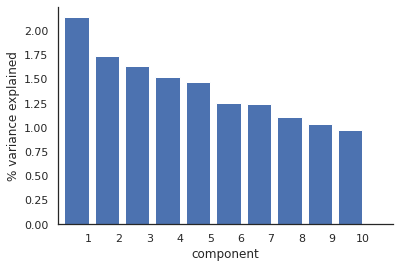

In [8]:
IDs = meta_data_samples.callset_index.values
pca_df = pruning_and_pca(gt, IDs, 3000000, 500, 2)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


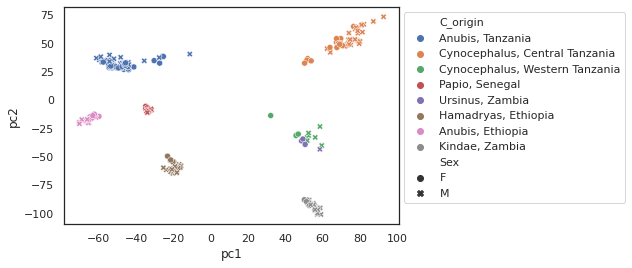

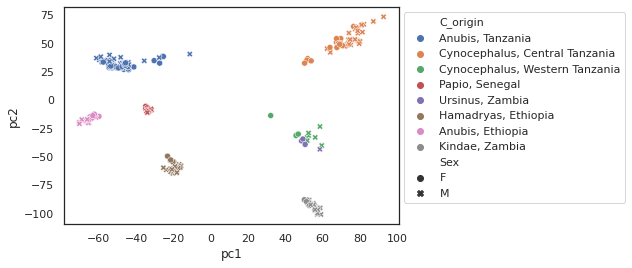

In [12]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="C_origin", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)
fig_males.savefig("../results/pca_x_with_males", bbox_extra_artists=[lgd], bbox_inches='tight')
fig_males

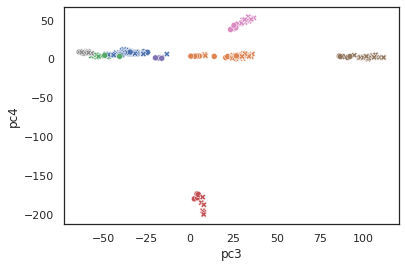

In [17]:
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc4", hue="C_origin", style="Sex")
scatter_sns.legend([],[], frameon=False)

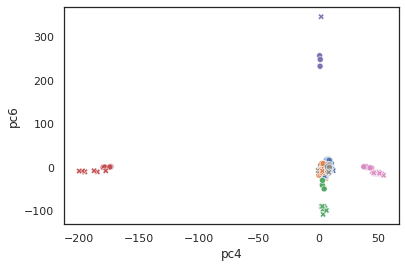

In [24]:
scatter_sns = sns.scatterplot(data = pca_df, x="pc4", y="pc6", hue="C_origin", style="Sex")
scatter_sns.legend([],[], frameon=False)

Loading the sites to keep, which I created in dp03

In [25]:
masked_sites = np.load("../data/kept_pos_x_female.npy")
gt_masked_sites = gt.take(masked_sites, axis=0)

Investigating 89 individuals
iteration 1 retaining 79031 removing 1360346 variants
iteration 2 retaining 7731 removing 71300 variants


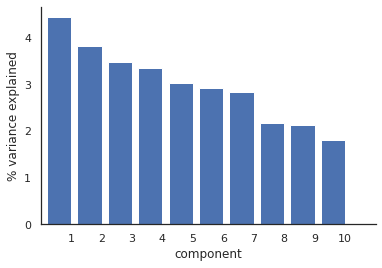

In [26]:
IDs = meta_data_samples.loc[(meta_data_samples.x_missing <= 0.01)
                             & (meta_data_samples.Sex == "F")].callset_index.values
pca_df = pruning_and_pca(gt_masked_sites, IDs, 3000000, 500, 2)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


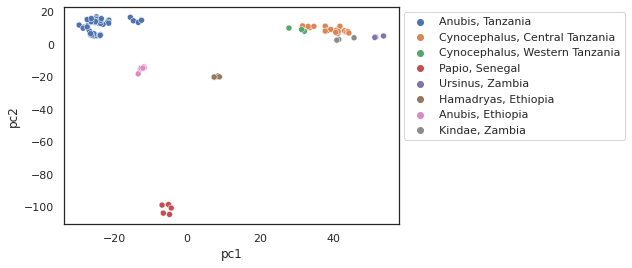

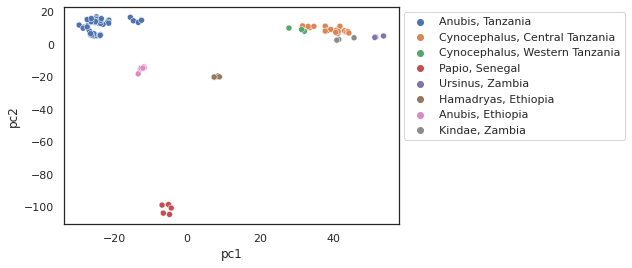

In [28]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)
fig_females.savefig("../results/pca_x_females", bbox_extra_artists=[lgd], bbox_inches='tight')
fig_females

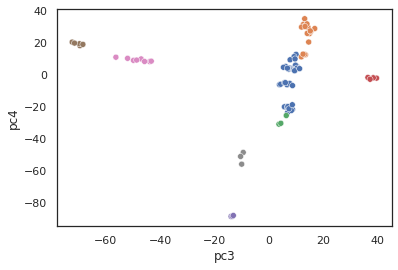

In [31]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc4", hue="C_origin")
scatter_sns.legend([],[], frameon=False)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


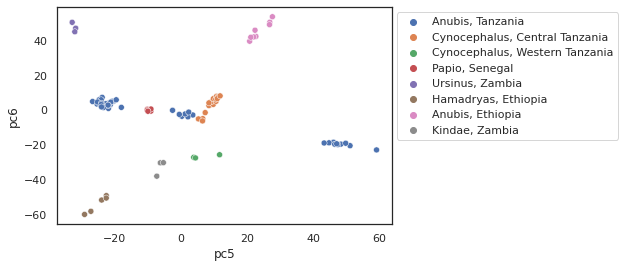

In [30]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc5", y="pc6", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

In [ ]:
IDs = meta_data_samples.loc[(meta_data_samples.x_missing <= 0.01)
                             & (meta_data_samples.Sex == "F")].callset_index.values
pca_df = pruning_and_pca(gt, IDs, 3000000, 500, 2)

In [ ]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

In [ ]:
#Only taking 10 individuals per Species.
females = meta_data_samples.loc[(meta_data_samples.Sex == "F")  & (meta_data_samples.x_missing <= 0.01)]
IDs = []

for species in meta_data_samples.Species.unique():
    species_IDs = females.loc[females.Species == species]
    n = min(5, len(species_IDs))
    print("Taking {}, which are of speices {}".format(n, species))
    IDs.extend(np.random.choice(species_IDs.callset_index.values, n, replace=False))
pca_df = pruning_and_pca(gt_masked_sites, IDs, 3000000, 500, 2)

In [ ]:
pca_df.iloc[:, [0,1,15]]

In [ ]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)